In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

In [65]:
# Color palette
cmap = sns.color_palette("Blues")
# Properties
batch_size = 32
img_height = 180
img_width = 180

In [66]:
print("Color scheme:", end="\n\n")
cmap

Color scheme:



[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

In [67]:
# Set path of the train directory
train_dir = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
test_dir = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

In [68]:
# Create a function to customize autopct parameter of plt.pie()
def make_autopct(values):
    def my_autopct(pct):
        # The pct is percentage value that matplotlib supplies for every wedge
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.2f}%  ({val})'
    return my_autopct

# **Data Processing**

In [69]:
# Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [70]:
# Create Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [71]:
# Get labels inferred by the method itself
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


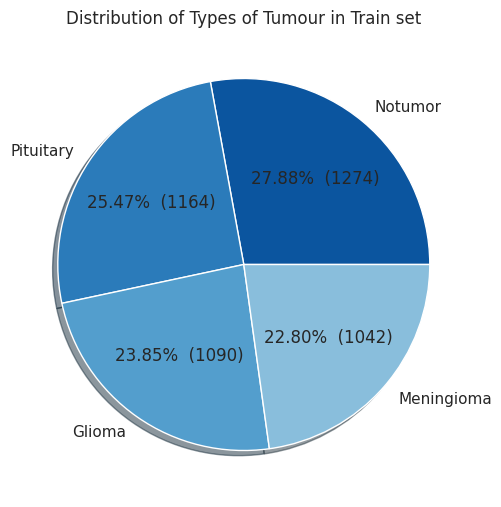

In [72]:
# Visualize Train Dataset
# Count instances in each class of train dataset
train_ds_labels = []

for _, labels in train_ds:
    for i in range(len(labels)):
        train_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': train_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our training data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Train set")
plt.show()

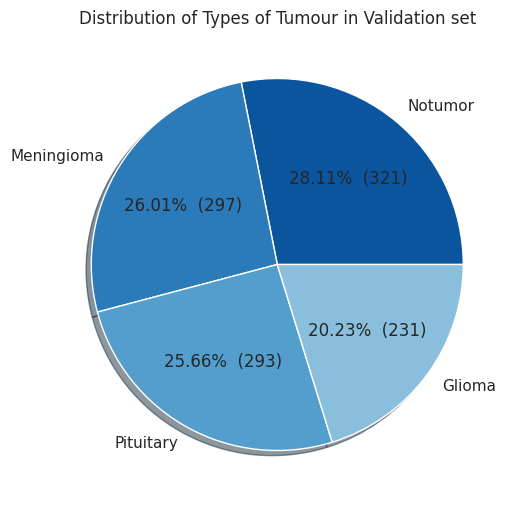

In [73]:
# Visualize Validation Dataset
# Count instances in each class of validation set
val_ds_labels = []

for _, labels in val_ds:
    for i in range(len(labels)):
        val_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': val_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our validation data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Validation set")
plt.show()

In [74]:
def plot_images(n_rows, n_cols, data_set):
    """
    Plots a figure containing all images in paths_img
    along with paths_label
    
    Parameters:
    n_rows: number of rows to plot in figure
    n_cols: number of cols to plot in figure
    data_set: The dataset of images to plot
            data_set type: tf.data.Dataset
    """
    plt.figure(figsize=(n_cols*2.25, n_rows*2.25))
    for images, labels in train_ds.take(1):
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

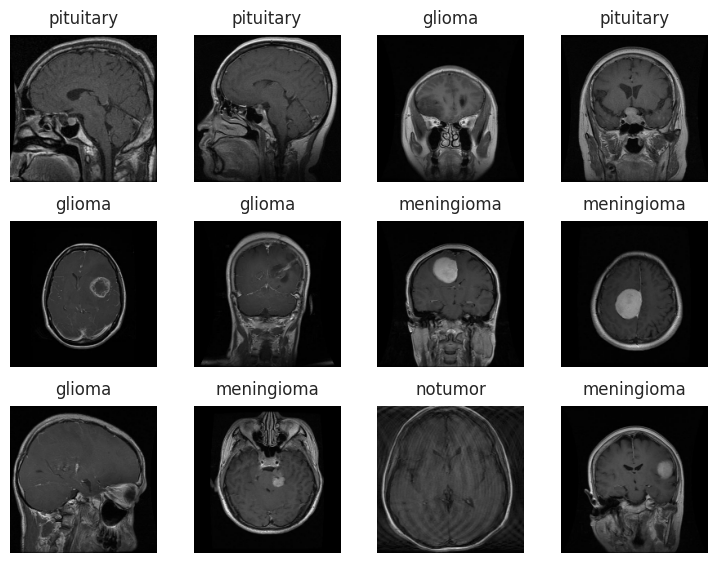

In [75]:
# View a few Images from Training dataset
plot_images(3, 4, train_ds)

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Standardize data and Data Augmentation**

In [77]:
# Now we will scale pixels from range 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [78]:
# Apply some techniques like flip, rotate and zoom
# inorder to increase the quality and amount of data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [79]:
def plot_images_augmented(dataset):
    """
    Parameters:
    : dataset - dataset of type `tf.data.Dataset` 
                with images to plot
    """
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

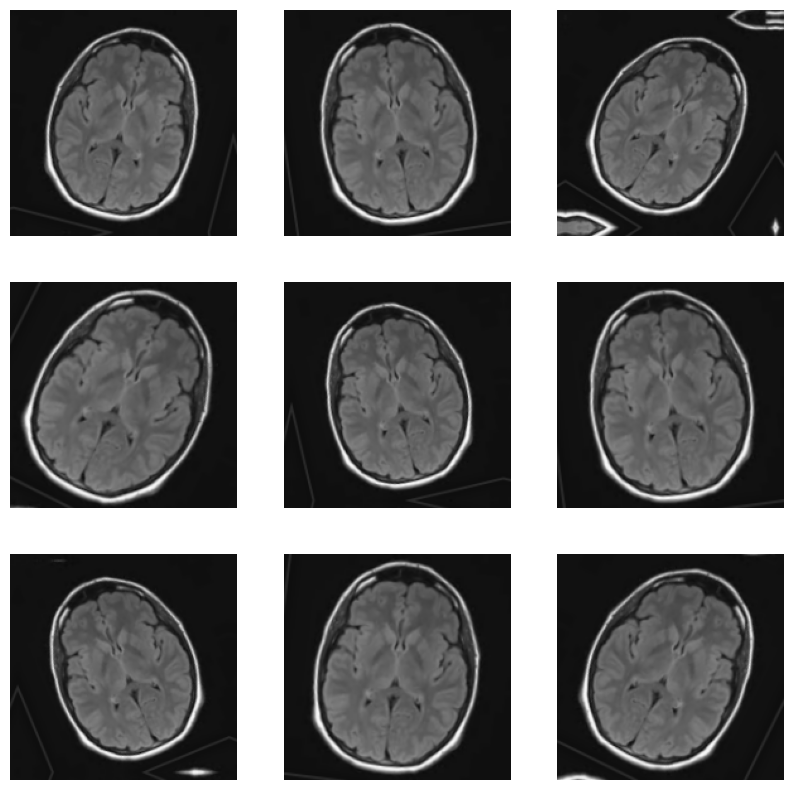

In [80]:
plot_images_augmented(train_ds)

# **Train Model**

In [81]:
# Number of classes in dataset (for output layer)
num_classes = len(class_names)

# Create Model
model = keras.Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [82]:
# Compile the above model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
# Look at the model's layers along with the number of parameters
# and shape of the input each layer accepts
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [84]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/modelCheckpoint/brainTumor_detect.h5"
)
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [85]:
# Fit model with our train data and cal-c validation 
# score at each epoch
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
# Model is saved again! (at different path)
model.save("brainTumor_detect.h5")

Epoch 1/10
143/143 [==============================] - 241s 2s/step - loss: 0.8175 - accuracy: 0.6694 - val_loss: 0.6747 - val_accuracy: 0.7391
Epoch 2/10
143/143 [==============================] - 247s 2s/step - loss: 0.5712 - accuracy: 0.7775 - val_loss: 0.6839 - val_accuracy: 0.7592
Epoch 3/10
143/143 [==============================] - 239s 2s/step - loss: 0.4856 - accuracy: 0.8136 - val_loss: 0.5886 - val_accuracy: 0.7942
Epoch 4/10
143/143 [==============================] - 243s 2s/step - loss: 0.4136 - accuracy: 0.8405 - val_loss: 0.5246 - val_accuracy: 0.8100
Epoch 5/10
143/143 [==============================] - 241s 2s/step - loss: 0.3877 - accuracy: 0.8512 - val_loss: 0.6216 - val_accuracy: 0.7881
Epoch 6/10
143/143 [==============================] - 234s 2s/step - loss: 0.3569 - accuracy: 0.8661 - val_loss: 0.3097 - val_accuracy: 0.8932
Epoch 7/10
143/143 [==============================] - 240s 2s/step - loss: 0.3002 - accuracy: 0.8825 - val_loss: 0.3237 - val_accuracy: 0.8713

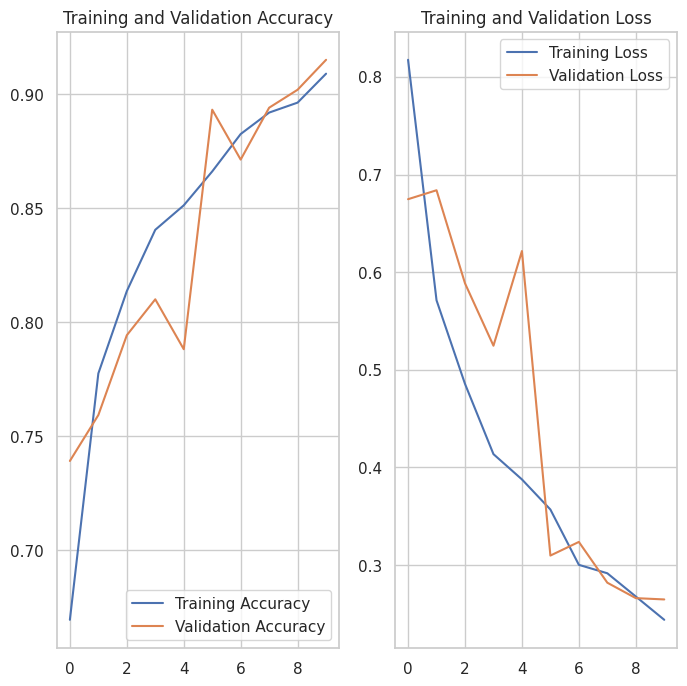

In [86]:
# Plot the training curves: train and validation accuracy & loss
epochs = len(history.epoch) # epochs completed by early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Evaluate Model**

In [87]:
# Read test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1311 files belonging to 4 classes.


In [88]:
# Make predictions on test set
predictions = model.predict(test_ds)
# We use tf.nn.softmax as we applied padding in training & task is of multiclass 
# prediction. Threfore, we used `SparseCategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

41/41 [==============================] - 20s 462ms/step


In [89]:
for i in range(0, 10):
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

This image most likely belongs to meningioma with a 87.35 percent confidence.
This image most likely belongs to glioma with a 86.09 percent confidence.
This image most likely belongs to notumor with a 95.56 percent confidence.
This image most likely belongs to pituitary with a 99.52 percent confidence.
This image most likely belongs to meningioma with a 97.31 percent confidence.
This image most likely belongs to pituitary with a 99.71 percent confidence.
This image most likely belongs to notumor with a 99.98 percent confidence.
This image most likely belongs to pituitary with a 97.86 percent confidence.
This image most likely belongs to pituitary with a 90.91 percent confidence.
This image most likely belongs to meningioma with a 82.77 percent confidence.


In [90]:
accuracy = model.evaluate(test_ds)

41/41 [==============================] - 19s 463ms/step - loss: 0.3338 - accuracy: 0.8749


In [91]:
print(f"Accuracy of model is {round(accuracy[1]*100, 2)}%")

Accuracy of model is 87.49%
